In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

import warnings

import sklearn
import sklearn.ensemble
import sklearn.inspection
from sklearn.model_selection import train_test_split

from datetime import datetime, timedelta

**Prelude: Saving Pictures**

This is just a function to help resolve some of the issues I sometimes faced while trying to save plots. I kept it in a seperate file during the first assignment.<br> I'm including it here this time since the assignment specified that all code should be contained in a single notebook.

In [2]:
from matplotlib import rcParams
import os


# This is to prevent labels being cut off when
# saving figures as images on the disk.
rcParams.update({'figure.autolayout': True})

# This is the folder to which all charts will be
# saved.
SAVE_DIR = "charts"
    
    
def plt_save(name, parent = None):
    """
    Save the current matplotlib figure to
    the save dir in the form "name_kind.png"
    
    If a parent path is given, save to that
    subfolder of the save dir.
    """
    
    # Add the save_dir to the parent path
    
    if parent is None:
        parent = SAVE_DIR
    else:
        parent = SAVE_DIR + "/" + parent
    
    # Try to ensure that the target path exists.
    
    # If there is an exception here, it is most likely
    # because the path does already exist.
    
    try:
        os.makedirs(parent)
    except:
        pass
    
    # Create the path and save the figure.
    
    path = f"{parent}/{name}.png"
    
    plt.savefig(path)
 

Part 1: Data Understanding and Preparation
==

**Note:** The first part of section, r.e. understanding, is largely a recap of assignment 1 part 3. It is a little different in that in includes the new features from part 4, while excluding the trivia/consistency check section. It also acts on a training set of data rather than the whole data, though this had little to no effect on the plots below.

The second part for preparation is new.

Read in the data, after the modifications made in assignment 1.

(This is after dropping columns and creating new features)

In [305]:
a1_data = pd.read_csv("assignment1-data.csv", index_col=0)

# Categorical columns
cat_features = [
    "current_status",
    "sex",
    "age_group",
    "race_ethnicity_combined",
    "hosp_yn",
    "icu_yn",
    "death_yn",
    "medcond_yn",
    "pos_spec_declared",
    "symptoms_declared"
]

# Convert the categorical columns from plain python
# objects to pandas categories
for feature in cat_features:
    a1_data[feature] = a1_data[feature].astype("category")
    
# The only non-categorical column at the moment is
# "case_age", which is a time span.

a1_data["case_age"] = pd.to_timedelta(a1_data["case_age"])

# The number of days is an easier value to work with than
# the full internal representation of a python timedelta.
a1_data["case_age_days"] = a1_data["case_age"].map(lambda td: td.days)

display(a1_data.dtypes)
a1_data.head(3)

cdc_case_earliest_dt                object
current_status                    category
sex                               category
age_group                         category
race_ethnicity_combined           category
hosp_yn                           category
icu_yn                            category
death_yn                          category
medcond_yn                        category
case_age                   timedelta64[ns]
pos_spec_declared                 category
symptoms_declared                 category
case_age_days                        int64
dtype: object

,cdc_case_earliest_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn,case_age,pos_spec_declared,symptoms_declared,case_age_days
0,2020-08-25,Laboratory-confirmed case,Female,30 - 39 Years,Hispanic/Latino,No,Unknown,No,Unknown,246 days 15:40:02.408061,Yes,True,246
1,2020-12-15,Laboratory-confirmed case,Female,10 - 19 Years,"Black, Non-Hispanic",No,Unknown,No,No,134 days 15:40:02.408061,Yes,False,134
2,2020-09-21,Laboratory-confirmed case,Female,10 - 19 Years,Unknown,No,Unknown,No,Unknown,219 days 15:40:02.408061,No,True,219


Perform a train-test split.

In [306]:
y = a1_data["death_yn"]
X = a1_data.drop("death_yn", axis=1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

# Combine the training data for the sake of plotting
train_data = X_train.copy()
train_data["death_yn"] = y_train

print("Train #:", len(X_train), len(y_train))
print("Test #:", len(X_test), len(y_test))
train_data.head(2)

Train #: 6503 6503
Test #: 2787 2787


,cdc_case_earliest_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,medcond_yn,case_age,pos_spec_declared,symptoms_declared,case_age_days,death_yn
7843,2020-11-30,Laboratory-confirmed case,Male,50 - 59 Years,"White, Non-Hispanic",Unknown,Unknown,Unknown,149 days 15:40:02.408061,Yes,False,149,No
5303,2020-12-01,Laboratory-confirmed case,Male,20 - 29 Years,"White, Non-Hispanic",Unknown,Unknown,Unknown,148 days 15:40:02.408061,Yes,False,148,No


Similar to assignment 1, use stacked plots to compare pairwise features.
<br>Only use the training data this time though.

In [307]:
def plot_stacked_proportions(x_field, y_field, ax = None):
    
    if ax is None:
        ax = plt.gca()
    
    stacks = train_data.value_counts().groupby([x_field, y_field]).sum().unstack()

    stacks = stacks.T

    for column in stacks:
        stacks[column] /= stacks[column].sum()

    stacks.T.plot(kind="bar", stacked=True, ax = ax)

Also similar before, I find it useful to split up each feature in the dataset into two categories.

Part 1: Status of the case

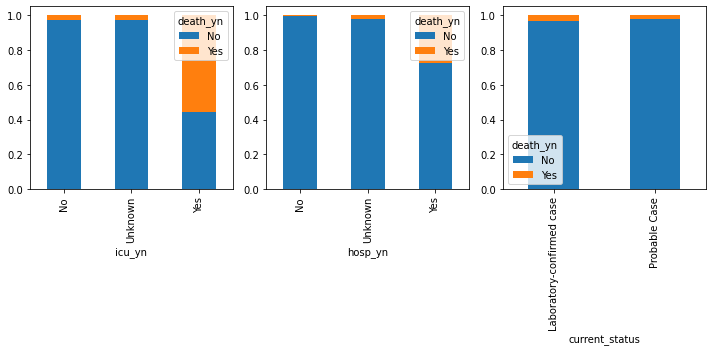

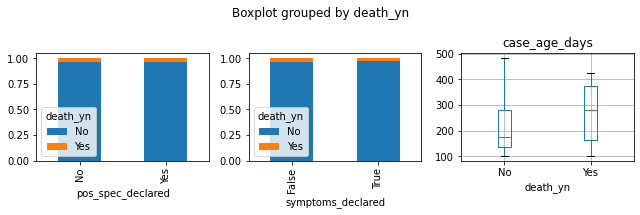

In [308]:
# Same as in assignment 1

fig, ax = plt.subplots(1, 3, figsize=(10,5))

plot_stacked_proportions("icu_yn", "death_yn", ax[0])
plot_stacked_proportions("hosp_yn", "death_yn", ax[1])
plot_stacked_proportions("current_status", "death_yn", ax[2])

plt_save("case status I", "relationships")


# This time, also consider new features.

fig, ax = plt.subplots(1,3, figsize=(9,3))

plot_stacked_proportions("pos_spec_declared", "death_yn", ax[0])
plot_stacked_proportions("symptoms_declared", "death_yn", ax[1])

# Minor note: as per the suggestion the feedback from the previous assignment,
# I went back and was more careful with date formats in the data prep.
# It worked! The case_age is no longer has non-sensical negative values.

train_data.boxplot("case_age_days", by="death_yn", ax=ax[2])

plt_save("case status II", "relationships")

Part 2: Traits of the patient:

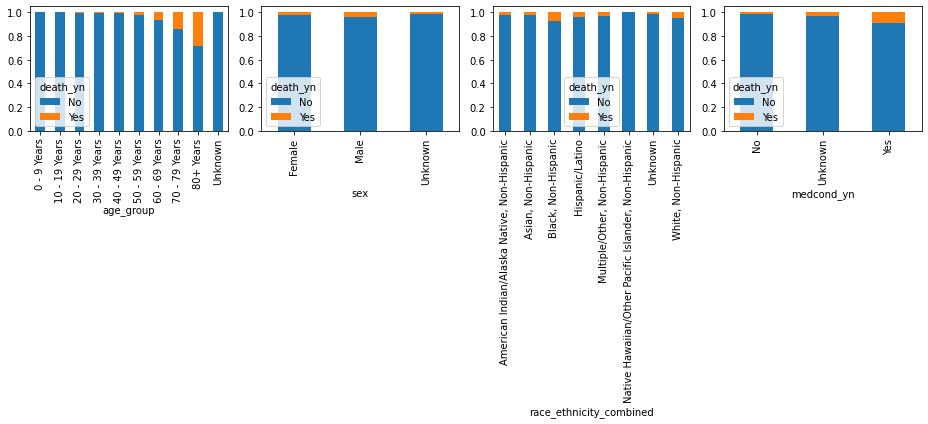

In [309]:
fig, ax = plt.subplots(1, 4, figsize=(13,6))

plot_stacked_proportions("age_group", "death_yn", ax[0])
plot_stacked_proportions("sex", "death_yn", ax[1])
plot_stacked_proportions("race_ethnicity_combined", "death_yn", ax[2])
plot_stacked_proportions("medcond_yn", "death_yn", ax[3])

plt_save("traits", "relationships")

The question then is which of these feature to choose.

All are interesting to some extent, and I think as part of part 4 I might try a model with all of them.


But for now, to keep things simple, I'll choose the top five that seem most significant too me. (From a purely visual inspection of the graphs above)

  - icu_yn
  - age_group
  - hosp_yn
  - case_age_days
  - medcond_yn

In [310]:
iter1_data = a1_data[[
    "icu_yn",
    "age_group",
    "hosp_yn",
    "case_age_days",
    "medcond_yn",
    "death_yn"
]]

Before continuing to models and training, it's worth pausing and dealing with the fact that most of these ae categorical variables.

For now, I'm just going to use ordinal encoding for each. This could be very bad since it links missing values strongly with yes, I think, for linear regression anyways. (Since no is 0, and missing and yes are positive)

The encodings will be normalized as well, for the sake of explaining weights later on.

The function below expects Yes/No/Missing columns, and won't work for `age_group`. That feature we'll come to next. 

In [697]:
def encode_single_ordinal(series):
    
    # It makes intuitive sense to put "Unknown" between
    # "Yes" and "No". This is actually very important, without it, 
    # the logistic model performs much much worse. I discovered this by teaking these
    # values on a whim at some point, and won't mention it after this - part 5 has
    # enough going on as is.
    encoding = {
        "No": 0,
        "Unknown": 1,
        "Yes": 2
    }
    
    new_series = series.replace(encoding)
    
    #new_series = pd.Categorical(series, ["No", "Yes", "Unknown"])
    #new_series = pd.Series(new_series, index=series.index).cat.codes
    
    new_series = new_series.astype(str).replace(encoding).astype(int)
    
    # Normalize. A simple min-max makes sense since there are only 3 classes.
    new_series = (new_series - new_series.min()) / (new_series.max() - new_series.min())
    
    return new_series
    
    
def encode_all_ordinal(df, ignore=[]):

    for feature in df:

        if feature in ignore:
            continue
        
        if str(df.dtypes[feature]) != "category": 
            continue
            
        df[feature] = encode_single_ordinal(df[feature])
        

# Quick test
data = iter1_data.copy()
display(data.head(4))
encode_all_ordinal(data, ignore=["age_group"])
display(data.head(4))

,icu_yn,age_group,hosp_yn,case_age_days,medcond_yn,death_yn
0,Unknown,30 - 39 Years,No,246,Unknown,No
1,Unknown,10 - 19 Years,No,134,No,No
2,Unknown,10 - 19 Years,No,219,Unknown,No
3,Unknown,20 - 29 Years,Unknown,114,Unknown,No


,icu_yn,age_group,hosp_yn,case_age_days,medcond_yn,death_yn
0,0.5,30 - 39 Years,0.0,246,0.5,0.0
1,0.5,10 - 19 Years,0.0,134,0.0,0.0
2,0.5,10 - 19 Years,0.0,219,0.5,0.0
3,0.5,20 - 29 Years,0.5,114,0.5,0.0


The only categorical value that is *actually* ordinal here is `age_group`, so we need to take with the ordering for that one. 
<br>
Also, "Unknown" in an ordinal age makes little sense, so I'll impute it with the mode for now. 

In [584]:
def encode_age(df):

    # Impute the mode for age_group Unknown.
    # This is a temporary measure! I'll introduce an indicator variable
    # in part 5, but I wanted to keep things as simple as possible for the
    # first iteration.
    mode = original.age_group.mode().values[0]
    df.age_group = original.age_group.replace("Unknown", mode)

    # I'm not sure this makes any difference, but reconstruct the category
    # with ordered = True (it is false by default).
    # Also make sure that the labels are in order (Though I think they are automatically sorted anyways)
    labels = sorted(df.age_group.unique())
    df.age_group = pd.Categorical(df.age_group, categories=labels, ordered=True)

    # Convert to numerical and normalize
    df.age_group = df.age_group.cat.codes
    age = df.age_group
    df.age_group = (age - age.min()) / (age.max() - age.min())


# Quick test.
original = iter1_data
new_df = original.copy()
encode_age(new_df)
display(pd.DataFrame([
    original.head(10).age_group, 
    new_df.age_group.head(10)
], index=["label", "numerical"]))

,0,1,2,3,4,5,6,7,8,9
label,30 - 39 Years,10 - 19 Years,10 - 19 Years,20 - 29 Years,60 - 69 Years,20 - 29 Years,40 - 49 Years,60 - 69 Years,80+ Years,50 - 59 Years
numerical,0.375,0.125,0.125,0.25,0.75,0.25,0.5,0.75,1,0.625


Apply the various encodings on the data to create a normalized, numerical only dataset

In [661]:
def normalize_case_age(df):
    
    feature = "case_age_days"
    u = df[feature].min()
    s = df[feature].std()
    df[feature] = (df[feature] - u) / (3 * s)
    


def iter1_encode(df):
    
    encode_all_ordinal(df, ignore="age_group")
    encode_age(df)
    
    # Normalize the one field that was originally numerical.
    # The rest will have been normalized as part of encoding above.
    normalize_case_age(df)

data = iter1_data.copy()
iter1_encode(data)
data.head(4)

,icu_yn,age_group,hosp_yn,case_age_days,medcond_yn,death_yn
0,0.5,0.375,0.0,0.548309,0.5,0.0
1,0.5,0.125,0.0,0.121846,0.0,0.0
2,0.5,0.125,0.0,0.445501,0.5,0.0
3,0.5,0.250,0.5,0.045692,0.5,0.0


Perform the train-test split on the choice of features.

For the ease of use on the coming sections, I found it handy to store the various segments of data in a single container variable, since they are often passed around together in practice.

In [586]:
class Container:
    pass


def get_case_study(data_n):
    
    X = data_n.drop("death_yn", axis=1)
    y = data_n["death_yn"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)
    
    data = Container()
    data.X = X
    data.y = y
    data.X_train = X_train
    data.y_train = y_train
    data.X_test = X_test
    data.y_test = y_test
    
    return data


# The first attempt, with the default encodings.
data = iter1_data.copy()
iter1_encode(data)
iter1 = get_case_study(data)

Part 2: Linear Model
==

In [587]:
linear = sklearn.linear_model.LinearRegression

Fit a linear model using the numerical training sets.

In [588]:
def model_info(model_type, data):
    
    try:
        model = model_type(random_state=0)
    except:
        model = model_type()
    
    model.fit(data.X_train, data.y_train)
    
    model_info = pd.DataFrame(model.intercept_.reshape(1,1), columns=["intercept"])
    model_info[data.X_train.columns] = pd.DataFrame(model.coef_.reshape(1, model.coef_.size))
    
    return model_info

,intercept,icu_yn,age_group,hosp_yn,case_age_days,medcond_yn
0,-0.139605,0.047549,0.171153,0.1387,0.062157,0.023527


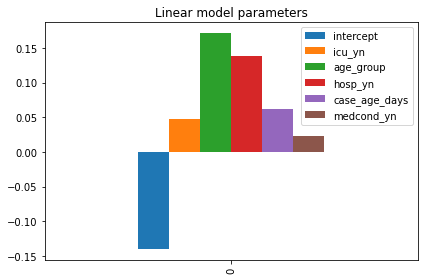

In [589]:
info = model_info(linear, iter1)
display(info)
info.plot(kind="bar", title="Linear model parameters");

The features are normalized, and I think the normalized distributions are okay, so the weights and intercept can be compared directly.

**intercept**
This is quite negative - even if all of the other features are maxed out, the model won't give a very high confidence of their being a death.

**icu, hsp, and med_cond**
These were crippled by the ordinal encoding, I think. Putting missing after yes means that when there is an overwhelming amount of missing and most of those could probably have been imputed as no, means the model can't weight "yes" without also weighting "no" as much or more. But we'll see if this holds true when indicator variables are used later in the notebook.

**age_group**
This is the most important feature after icu and hsp, so it's no surprise to see it take the fore after the others are gone.

**case_age_days**
It's nice to see the custom feature contributing here. It's positive, which means recent cases have a higher chance of being a death according to the model. I admit that goes against my intuition.

Next, some predictions.

In [590]:
def apply_threshold(prediction, threshold, labels):

    prediction = (prediction > threshold).astype(int)
    prediction = [labels[i] for i in prediction]
    
    return prediction


def predict(model_type, data, threshold=None, labels=None, training_only=False):

    try:
        model = model_type(random_state=0)
    except:
        model = model_type()
    
    model.fit(data.X_train, data.y_train)

    if training_only:
        prediction = model.predict(data.X_train)
    else:
        prediction = model.predict(data.X_test)
        
    if threshold is not None:
        if labels is None:
            labels = np.sort(np.unique(data.y_train))
        prediction = apply_threshold(prediction, threshold, labels)
        
    return pd.Series(prediction)

The first 10 predict false. This is not very surprising, giving the expected proportions.

In [591]:
# Predict for training data, not test data!
prediction = predict(linear, iter1, training_only=True)

prediction = pd.DataFrame(prediction, columns=["value"])
prediction["class"] = prediction.value > 0.5

display(prediction.head(10))

,value,class
0,-0.019096,False
1,-0.053088,False
2,-0.071549,False
3,0.017578,False
4,0.112489,False
5,0.010912,False
6,0.005507,False
7,0.040915,False
8,-0.075099,False
9,0.072397,False


Below are functions to help calculate the confusion matrix and positive rates, for a given threshold.

I recognize in hindsight that a lot of these little functions I have scattered about the place have premade and more complete implementations in sklearn or skplot. But on the upside, it was a reminder of what the various formulae actually mean.

In [592]:
def confusion(actual, prediction, labels=None):
    
    if labels is None: labels = np.sort(np.unique(actual))
    
    matrix = sklearn.metrics.confusion_matrix(actual, prediction, labels=labels)
    matrix = pd.DataFrame(matrix, index = ["Alive", "Dead"], columns = ["Alive", "Dead"])
    
    return matrix


def rates(matrix):
    
    matrix = matrix.values
    tp = matrix[1,1] / matrix[1,:].sum() # true positive
    fp = matrix[0,1] / matrix[0,:].sum() # false positive
    tn = matrix[0,0] / matrix[0,:].sum() # true negative
    fn = matrix[1,0] / matrix[1,:].sum() # false negative
    
    names = [
        "true positives",
        "false positives",
        "true negatives",
        "false negatives"
    ]
    
    return pd.DataFrame([[tp, fp, tn, fn]], columns=names)

The results with 0.5 as the threshold are terrible - 0 true positives.

This is exactly the same as the baseline prediction of always choosing false.

In [593]:
prediction = predict(linear, iter1, training_only=True, threshold=0.5)
actual = iter1.y_train

matrix = confusion(iter1.y_train, prediction)

display(matrix)
display(rates(matrix))

,Alive,Dead
Alive,6263,0
Dead,240,0


,true positives,false positives,true negatives,false negatives
0,0.0,0.0,1.0,1.0


With this in mind, the other metrics probably won't tell us much we don't already know, but I'll print them out anyways:

In [594]:
def class_metrics(matrix):
    
    matrix = matrix.values
    tn = matrix[0,0]
    fp = matrix[0,1]
    fn = matrix[1,0]
    tp = matrix[1,1]
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    F1 = 2 * precision * recall / (precision + recall)
    
    index = ["accuracy", "precision", "recall", "F1"]
    result = pd.Series([accuracy, precision, recall, F1], index)
    
    return result

In [595]:
prediction = predict(linear, iter1, training_only=True, threshold=0.5)
actual = iter1.y_train

matrix = confusion(actual, prediction)
class_metrics(matrix)

C:\Users\Kieran\miniconda3\envs\titanic\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  # Remove the CWD from sys.path while we load stuff.


accuracy     0.963094
precision         NaN
recall       0.000000
F1                NaN
dtype: float64

  - **Accuracy is high**. Well, given the overwhelming number of negatives in the dataset, always predicting negative yields a very high accuracy we are almost always right.
  - **Precision is undefined**, since there are no positives in the predictions on which to base it
  - **Recall is 0**. We never predicted positive.
  - **F1 is undefined**, since it is based on precision and precision is undefined.
  
Technically, it is possible to calculate F1 by cancelling terms in the limit towards zero positives. The result is 0, which isn't anything new though.

Looking at the hold-out, the result is almost identical. The threshold is much too high.

This needs to be fixed before I can continue with this question.

In [596]:
prediction = predict(linear, iter1, threshold=0.5)
actual = iter1.y_test

matrix = confusion(actual, prediction)
class_metrics(matrix)

C:\Users\Kieran\miniconda3\envs\titanic\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  # Remove the CWD from sys.path while we load stuff.


accuracy     0.965554
precision         NaN
recall       0.000000
F1                NaN
dtype: float64

Aside: The Threshold
--

Okay. So I'm guessing the ordinal encoding was a bad idea, but it could also just be the overwhelming prevelance of "no death" in the data that is causing a low viable threshold. I'll leave the attempt to rememdy those two for part 5, and focus on the threshold itself for now.

First, plot the distribution of the predictions to get an idea for what is going on.

<AxesSubplot:ylabel='Frequency'>

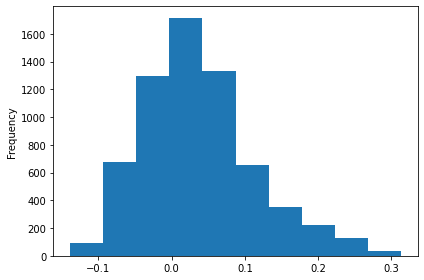

In [597]:
predict(linear, iter1, training_only=True).plot(kind="hist")

Nothing beyond 0.25. 

0.1 seems a decent candidate.

In [598]:
prediction = predict(linear, iter1, threshold=0.1)
actual = iter1.y_test

matrix = confusion(actual, prediction)
display(matrix)
display(class_metrics(matrix))

,Alive,Dead
Alive,2334,357
Dead,10,86


accuracy     0.868317
precision    0.194131
recall       0.895833
F1           0.319109
dtype: float64

Not fantastic, given that a positive result is much more likely to be a false positive than not. Accuracy has decreased and precision is quite low. F1 is low.

Nonethless, most of the true negatives are being caught now, which is a huge improvement. 

The next cell defines functions for getting ROC information.

In [609]:
def roc(actual, prediction, thresholds, labels=None):
    
    if labels is None:
        labels = np.sort(np.unique(actual))
    
    items = list()
    for threshold in thresholds:
        
        p_current = apply_threshold(prediction, threshold, labels)

        matrix = confusion(actual, p_current)
        tp = matrix.values[1,1] / matrix.values[1,:].sum()
        fp = matrix.values[0,1] / matrix.values[0,:].sum()
        
        items.append([tp, fp])

    # each item in "rates" is a pair: a true positive, 
    # and a false positive.
    
    cols = ["true_p", "false_p"]
    roc = pd.DataFrame(items, index=thresholds, columns=cols)
    
    return roc


def plot_roc(roc_data, ax=None):

    if ax is None:
        ax = plt.gca()
    
    # The basic plot - false vs. true positives
    
    plt.title("ROC for linear model")
    plt.xlabel("False Positives")
    plt.ylabel("True Positives")
    ax.plot(roc_data.false_p, roc_data.true_p, "-")
        

def auroc(roc_data):
    
    x = roc_data.false_p
    y = roc_data.true_p
    
    # This interpolation & integration is giving me
    # a warning regarding error. I'm only looking for 
    # a rough guess for now though, so won't
    # try fix it.
    
    f = scipy.interpolate.interp1d(x, y)
    area = scipy.integrate.quad(f, 0, 1, limit=200)
    
    return area

The curve looks very very good for this model at first glance, though I suspect that that is just because the source data is mostly made of negatives, and so false positives are undervalued.

Area under ROC: 0.9376645104355669


C:\Users\Kieran\miniconda3\envs\titanic\lib\site-packages\ipykernel_launcher.py:50: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


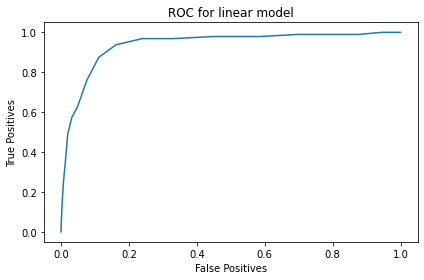

In [610]:
prediction = predict(linear, iter1)
actual = iter1.y_test


roc_data = roc(actual, prediction, np.linspace(-1, 1, 100))
plot_roc(roc_data)
print("Area under ROC:", auroc(roc_data)[0])

Some threshold values can be shown on the plot as well:

In [549]:
def show_thresholds(roc_data):

    distance = 0
    y1 = roc_data.true_p[roc_data.index[0]]

    for t in roc_data.index[1:]:

        # Don't display a threshold marker for every
        # point, since some are grouped together.
        # Wait until a certain y-distance has passed.
        
        x = roc_data.false_p[t]
        y2 = roc_data.true_p[t]

        distance += np.abs(y2-y1)
        y1 = y2
        
        if distance > 0.1:
            distance = 0
            plt.plot(x, y2, "o", color="#ff9900")
            plt.text(x + 0.04, y2, "t: %.2f" % t, color="#ff9900")

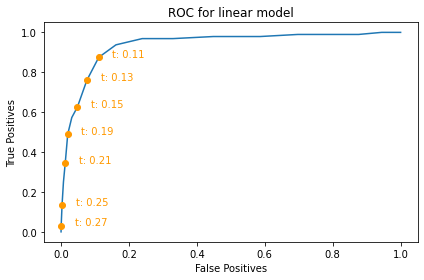

In [550]:
plot_roc(roc_data)
show_thresholds(roc_data)

From which I deduce that a threshold 0.1 is decent choice for now.

Finally, for the sake of later experimentation, we can define a heuristic for determining a decent threshold with code similar to that used for plotting ROC.

In [551]:
def find_threshold(actual, prediction, thresholds, labels=None):
    
    if labels is None:
        labels = np.sort(np.unique(actual))
    
    items = list()
    for threshold in thresholds:
        
        p_current = apply_threshold(prediction, threshold, labels)

        matrix = confusion(actual, p_current)
        metrics = class_metrics(matrix)
        items.append(metrics.F1)

    return pd.Series(items, index=thresholds).idxmax()

In [603]:
prediction = predict(linear, iter1)
actual = iter1.y_test

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    threshold = find_threshold(actual, prediction, np.linspace(-1,1,100))

print("Chosen threshold: %.04f" % threshold)

prediction = predict(linear, iter1, threshold)
matrix = confusion(actual, prediction)
metrics = class_metrics(matrix)

print("Results:")
display(matrix)
display(metrics)

Chosen threshold: 0.1919
Results:


,Alive,Dead
Alive,2638,53
Dead,49,47


accuracy     0.963402
precision    0.470000
recall       0.489583
F1           0.479592
dtype: float64

This cell will not run until the kfold function is defined later on, but it demonstrates that these results hold up with kfolding.

In [554]:
#kfold(10, linear, iter1, threshold=0.1919)

accuracy     0.959311
precision    0.448942
recall       0.493375
F1           0.467893
dtype: float64

Back to Part 2: Linear Model
==

Recap: these are the metrics for the model when predicting training data.

In [555]:
prediction = predict(linear, iter1, 0.1, training_only=True)
actual = iter1.y_train

matrix = confusion(actual, prediction)

display(matrix)
class_metrics(matrix)

,Alive,Dead
Alive,5337,926
Dead,21,219


accuracy     0.854375
precision    0.191266
recall       0.912500
F1           0.316245
dtype: float64

 - **accuracy is high** - Not as high as before, but nonetheless high. Expected due to the imbalance in the target feature.
 - **precision is low** - A predicted positive is significantly more likely to be a false positive than a true positive!
 - **recall is high** - Most of the actual positives were detected.
 - **F1 is low** - Much better than before, but nonetheless low. 

Now, for the hold-out data:

In [556]:
prediction = predict(linear, iter1, 0.1)
actual = iter1.y_test

matrix = confusion(actual, prediction)

display(matrix)
class_metrics(matrix)

,Alive,Dead
Alive,2334,357
Dead,10,86


accuracy     0.868317
precision    0.194131
recall       0.895833
F1           0.319109
dtype: float64

Almost identical before. In fact, it scores a little better. This is surprise to me - I'd have thought even a model not suffering from overfitting too much tends to perform better on the training data.

After seeing this trend a few times now in this notebook, I'm no longer so sure. I wonder is the model just simple enough (linear & 5 features) to avoid the problem.

Finally, k-fold cross-validation. 

In [557]:
def kfold(k, model_type, data, threshold=None):
    
    X = data.X.values
    y = data.y.values
    
    folder = sklearn.model_selection.KFold(k, shuffle=True, random_state=0)
    
    results = pd.Series([0.,0.,0.,0.], index=[
        "accuracy", "precision", "recall", "F1"
    ])
    
    labels = np.sort(np.unique(y))
        
    for train_index, test_index in folder.split(X, y):

        model = model_type()
        model.fit(X[train_index], y[train_index])
        prediction = model.predict(X[test_index])
        prediction = pd.Series(prediction)
        
        if threshold is not None:
            prediction = apply_threshold(prediction, threshold, labels)
        
        matrix = confusion(y[test_index], prediction, labels)
        metrics = class_metrics(matrix)
        
        for item in results.index:
            if not np.isnan(metrics[item]):
                results[item] += metrics[item]
    
    results /= k
        
    return results

In [558]:
kfold(50, linear, iter1, threshold=0.1)

accuracy     0.860075
precision    0.195197
recall       0.906816
F1           0.315385
dtype: float64

For low k (k < 50), the metrics are similar to those from the hold-out data.

As k increases, the F1 and other values (except for accuracy) tend to decrease, which seemed counter-intuitive at first. Surely more training data is a good thing?

However, there are lots and lots of NaN warnings printed out. I think what is happening is that as the test sample gets smaller, there are more and more samples with no predicted positives, and also more with no actual positives. This causes some of the metrics to go to NaN due to zero division errors, and contribute zero to the totals.

When I first ran this, accuracy tended to decrease too, but I was able to fix a similar error there - the confusion matrix was giving an error when there more no actual positives *and* no predicted positives.

In [559]:
with warnings.catch_warnings():
    
    # Comment out this to see a flood of warnings
    # relating to times when there were no predictions
    # and some metrics fall to NaN
    warnings.simplefilter("ignore")
    
    threshold = 0.1
    
    print("200 Iterations:")
    display(kfold(200, linear, iter1, threshold))
    
    print("400 Iterations:")
    display(kfold(400, linear, iter1, threshold))
    
    print("1000 Iterations:")
    display(kfold(1000, linear, iter1, threshold))

200 Iterations:


accuracy     0.859420
precision    0.189979
recall       0.746333
F1           0.289235
dtype: float64

400 Iterations:


accuracy     0.859728
precision    0.193928
recall       0.525208
F1           0.267082
dtype: float64

1000 Iterations:


accuracy     0.859833
precision    0.155217
recall       0.252917
F1           0.182436
dtype: float64

Part 3: Logistic Regression
==

In [560]:
logistic = sklearn.linear_model.LogisticRegression

,intercept,icu_yn,age_group,hosp_yn,case_age_days,medcond_yn
0,-10.555918,1.83713,6.126942,2.690406,1.205046,0.719347


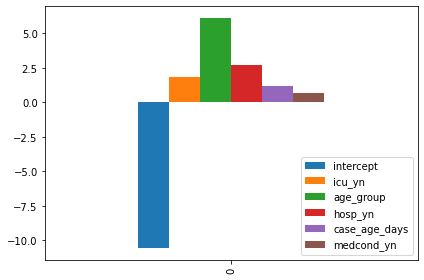

In [561]:
info = model_info(logistic, iter1)

display(info)
info.plot(kind="bar");

This graph of coefficients has similar properties to that for the linear model, which is no surprise. While the two models differ in the shape of the curve (or hyperplane) they apply to the data, they both follow a general principle of weighting significant features more, and, for our case, weighting risk factors against and initial intercept.

So age takes the lead as the most significant factor. I still think the y/n features are being undervalued here and will be more useful with indicator variables to support them. case_age_days is apprently not particularly significant in comparison to age.

In [562]:
prediction = predict(logistic, iter1, training_only=True)
prediction.head(10)

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
dtype: float64

In [563]:
prediction = predict(logistic, iter1, training_only=True)
actual = iter1.y_train

display(confusion(actual, prediction))
display(class_metrics(confusion(actual, prediction)))

,Alive,Dead
Alive,6227,36
Dead,184,56


accuracy     0.966169
precision    0.608696
recall       0.233333
F1           0.337349
dtype: float64

Low recall and high precision, combined to make an F1 that is lower than the ones I've come to expect from the linear model, which is interesting.

The accuracy is significantly higher, since the precision of the positive when it makes a positive is much higher.

In [564]:
prediction = predict(logistic, iter1)
actual = iter1.y_test

display(confusion(actual, prediction))
display(class_metrics(confusion(actual, prediction)))

,Alive,Dead
Alive,2677,14
Dead,76,20


accuracy     0.967707
precision    0.588235
recall       0.208333
F1           0.307692
dtype: float64

The metrics are much the same for training as for test data, as before. The test data scored a little better this time, but given the kfold results in the next cell that looks like noise to me rather than overfitting.

In [565]:
kfold(10, logistic, iter1)

accuracy     0.966631
precision    0.620144
recall       0.232206
F1           0.334285
dtype: float64

The model holds up well under kfolding - these metrics are roughly the same (maybe a little better) than the ones above.

Part 4: Random Forests
==

In [566]:
rforest = sklearn.ensemble.RandomForestClassifier

In [567]:
prediction = predict(rforest, iter1)
prediction.head(10)

0    0.0
1    0.0
2    0.0
3    0.0
4    1.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
dtype: float64

The interpretation of Random Forests is a lot trickier than for the previous two models. They are often described as black boxes, and I can see why.

I started by printing out a few decision trees using the code below (replacing the "count" parameter with a higher number), but it was quickly evident that the trees were all wildly different. And even if they were not, the full tree is quite large.

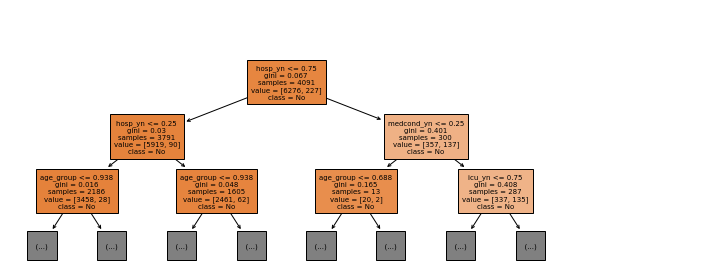

In [568]:
def show_trees(data, count):
    
    model = rforest(random_state=0)
    model.fit(data.X_train, data.y_train)
    
    for i in range(min(count, len(model.estimators_))):
        tree = model.estimators_[i]
        plt.figure(figsize=(10,4))
        sklearn.tree.plot_tree(tree, ax=plt.gca(), max_depth=2, filled=True, fontsize=7,
                              class_names=["No", "Yes"], feature_names=iter1.X.columns);
        
show_trees(iter1, count=1)

There are the "feature importance" metrics in SKLearn, which may provide some insight.

The first of these considers the change in certainty (or impurity) as a particular record moves down the tree. It tallies the contribution of each feature towards becoming more certain of a class. For example, if after splitting on a certain feature we move to a node with a greater "yes" proportion, we can say that that feature contributed towards a "yes" prediction.

<AxesSubplot:>

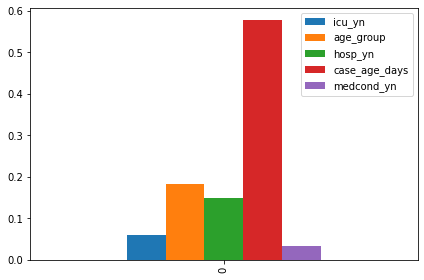

In [569]:
model = rforest(random_state=0)
model.fit(iter1.X_train, iter1.y_train)

results = model.feature_importances_ # This is an impurity based metric, according to the SKLearn docs.
pd.DataFrame([results], columns=iter1.X_train.columns).plot(kind="bar")

The results show case_age_days as being the most important by far, which is extremely surprising. 

This starts to make more sense when the warning on the SKLearn documentation is taken into account, which says that the importance for a feature with many classes may be overestimated - case_age_days, being spread out over 400 days or so, has many many more classes than the other features.

Furthermore, this method of estimating importance is based on training data only and does not take the loss of prediction skill when test data is considered.

The doc can be found here: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

The documentation points towards a simpler metric that can be based on test data rather than training data, where high-cardinality features and overfitting do not cause problems. This is called "permutation importance".

It corrupts one column at a time, takes the resulting decrease in score to be a measure of the importance of that feature. i.e. the more important the column, the more skill we lose when it is taken away.

The docs for this one can be found here: https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance

In [570]:
def permutation_importance(model_type, data, scoring=None, weights=None):

    try:
        model = model_type(random_state=0)
    except:
        model = model_type()
        
    model.fit(data.X_train, data.y_train)

    result = sklearn.inspection.permutation_importance(
        model, data.X_test, data.y_test, n_repeats=10, 
        random_state=0, scoring=scoring, sample_weight=weights)
    
    return pd.DataFrame([result["importances_mean"]], columns=data.X_train.columns)

<AxesSubplot:>

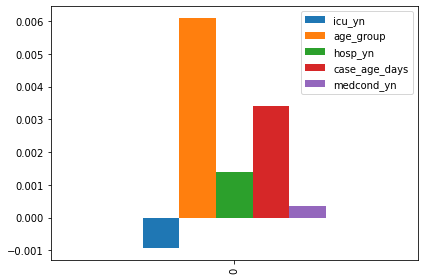

In [571]:
permutation_importance(rforest, iter1).plot(kind="bar")

This is more similar to the weights in the logistic/regression models, with the exception of icu. At first I was just confused by that in particular. (I cannot even blame the encoding this time, since a decision tree can choose ranges precisely and effectively re-encode things) 

However, it later occurred to me that the scoring metric was *accuracy* in this case. We know that because of the overwhleming imbalance in the target feature, any predictor that starts trying to predict with some recall tends to lose some accuracy. So icu being negative here is possibly a good thing.

That also means that removing the others each *decreased* accuracy, which is almost counter-intuitive now.

Before reading to much into this, though, and trying to explain it, I note that the magnitude of these changes is very, very small - less than 1%. All in all, this is deceptively nice looking graph, with simple intuitive origins, that is nonetheless hard to interpret.

A perhaps easier (if less directly intuitive) metric to deal with is F1.

<AxesSubplot:>

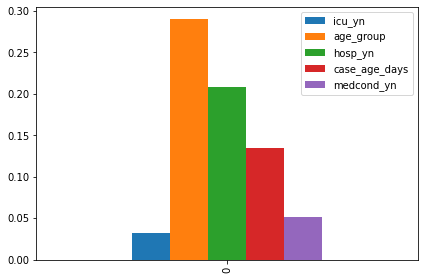

In [275]:
permutation_importance(rforest, iter1, "f1").plot(kind="bar")

Two things are immediately apparent - the proportionate change is score is much more significant now, and the magnitudes are as expected. 

It is still surprising to me that icu is so low. One thing to note is that the tree may spread out responsibility accross features acting as proxies to each other - it could be that between age_group and hosp_yn it has most of the information captured that icu_yn can give, or something like that.

We can also look at the accuracy each each class seperately.

<AxesSubplot:>

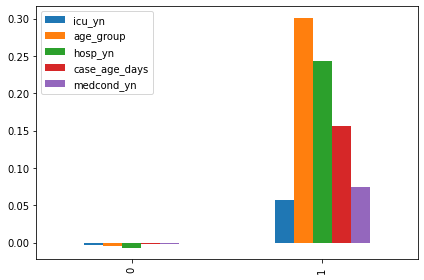

In [644]:
def feature_importances_by_class(data):

    # class 0
    weights = 1 - data.y_test
    result_0 = permutation_importance(rforest, data, "accuracy", weights)

    #class 1
    weights = data.y_test
    result_1 = permutation_importance(rforest, data, "accuracy", weights)
    result_1.index = [1]

    return pd.concat([result_0, result_1])

feature_importances_by_class(iter1).plot(kind="bar")

I like this graph in part because it highlights how small the effect on accuracy is in the positive case. The results for f1 scoring are reflected in the accuracy of the positive class.

The one issue I have with using permutation importance here is that it mixes scoring features with interpreting the model in a way that one cannot separate just looking at the graph. For all we know, there could be a feature that the tree uses all the time but that had little effect on the score. If the tree were to have that kind of strong hidden dependence on a feature, and the feature were to change dramatically, it could have unexpected effects.

That seems to be something the impurity based metric would be good at capturing. I gave a go at writing my own, based on test data rather than training data, in the hopes that it might avoid some of the pitfalls that are noted about the in-built one.

This attempt required a bit of rooting around the SKLearn docs. I found this link very very helpful:
https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py

It was an interesting rabbit hole, but the code is finicky and not well tested so I'm not at all confident that it is actually accurate!

In [318]:
def feature_importances(tree, data, prev_prediction=None):
    
    X = data.X_test
    y = data.y_test
    
    # We can precompute some values for each 
    # node in the tree to help performance a little.
    
    N = len(tree.value)
    decision = np.zeros(N) # If we stopped at this node, which would we choose?
    certainty = np.zeros(N) # How certain of the decision are we?
    features = [None]*N  # The relevant feature series from the training dataframe
    
    for node in range(N):
        
        a, b = tree.value[node][0]
        if a >= b:
            decision[node] = 0
        else:
            decision[node] = 1
        if a < b:
            a, b = b, a
        certainty[node] = a/(a+b)
        
        if tree.feature[node] >= 0:
            name = X.columns[tree.feature[node]]
            features[node] = X[name]
        
    # Now, follow the path of each record through the tree.
    # Record importances, but also record a prediction as a consistency
    # check, to help make sure we are correctly navigating the tree.
        
    importances = np.zeros(len(X.columns))
    importances_i = np.zeros(len(X.columns) + 1) # "+ 1" is to give the array a dummy slot used below.
    prediction = np.zeros(len(X))
    
    # I'm also interested in the breakdown of importance for yes vs no predictions
    
    importances_yes = np.zeros(len(X.columns))
    importances_no = np.zeros(len(X.columns))
    
    for record_i in range(len(X)):
        
        importances_i[:] = 0
        # This is the dummy slot in the array, since there is no initial
        # previous feature.
        previous_feature = len(importances_i) - 1 
        record = X.index[record_i]
        node = 0
        old_certainty = certainty[node]
        
        if prev_prediction is None:
            actual_value = y[y.index[record_i]]
        else:
            actual_value = prev_prediction[record_i]
        
        while True:
            
            # How has the previous branch affected certainty?
            
            new_certainty = certainty[node]
            delta = new_certainty - old_certainty
            
            if decision[node] != actual_value:
                # An increase in certainty in the wrong direction!
                delta *= -1
            
            importances_i[previous_feature] = delta
            
            # If we have reached a leaf, break
            
            if tree.children_left[node] == -1:
                break

            old_certainty = new_certainty
            previous_feature = tree.feature[node]
                
            # Figure out where to go next in the
            # tree.
                
            feature_value = features[node][record]
            threshold = tree.threshold[node]
            if feature_value <= threshold:
                node = tree.children_left[node]
            else:
                node = tree.children_right[node]
            
        prediction[record_i] = decision[node]
            
        # Normalize for the current run, so that longer paths
        # are not valued more than shorter paths
        importances_i /= np.abs(importances_i[0:-1]).sum()
        
        # Add to the overall tally. 
        # [0:-1] is because we do not include the dummy slot here.
        importances += importances_i[0:-1]
        if actual_value == 1:
            importances_yes += importances_i[0:-1]
        else:
            importances_no += importances_i[0:-1]
        
    # Normalize each so that they can be compared.
    importances /= np.abs(importances).sum()
    importances_yes /= np.abs(importances_yes).sum()
    importances_no /= np.abs(importances_no).sum()
            
    return prediction, importances, importances_yes, importances_no

Note - I'm printing out the predictions made by this function as well as the importances as a consistency check. They match below, but I've also seen them differ by a small amount occasionally - I think there might be some edge cases or minor details regarding comparison with which I have not matched the original SKLearn version.

,Actual,Test,Test II
0,2694,2694,2694
1,93,93,93


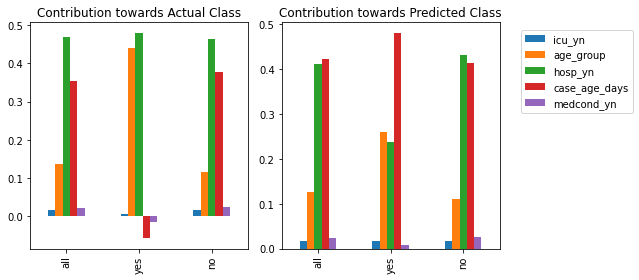

In [357]:
model = rforest(random_state=0)
model.fit(iter1.X_train, iter1.y_train)
dtree = model.estimators_[0]

data = iter1

# Actual prediction, according the SKLearn

actual_prediction = dtree.predict(data.X_test)

# Importances during our own navigation, comparing changes in
# certainty to the actual value.

test_prediction, i, i_yes, i_no = feature_importances(dtree.tree_, data)

# Importances during our own navigation, comparing changes in
# certainty to the final predicted value.

prev_prediction = test_prediction
test_prediction_2, i2, i2_yes, i2_no = feature_importances(dtree.tree_, data, prediction)

# Display

consistency = pd.DataFrame([
    pd.Series(actual_prediction).value_counts(), 
    pd.Series(test_prediction).value_counts(), 
    pd.Series(test_prediction_2).value_counts()
], index=["Actual", "Test", "Test II"], columns=[0, 1])
display(consistency.T)

_, ax = plt.subplots(1, 2, figsize=(9,4))

frame = pd.DataFrame([i, i_yes, i_no],
    columns=data.X_test.columns, 
    index=["all", "yes", "no"])
frame.plot(kind="bar", ax=ax[0], legend=False,
           title="Contribution towards Actual Class");

frame = pd.DataFrame([i2, i2_yes, i2_no],
    columns=data.X_test.columns, 
    index=["all", "yes", "no"])
frame.plot(kind="bar", ax=ax[1],
          title="Contribution towards Predicted Class");
plt.legend(loc=(1.1,0.6))

The above graphs are just for one tree. It's actually quite fun to cycle through the trees - while there are general trends, some are so different from the others.

Next, average the result across all trees. This cell takes a long time to run, so I've commented out the actual lines generating the graph and am displaying the picture displaying instead, for now.

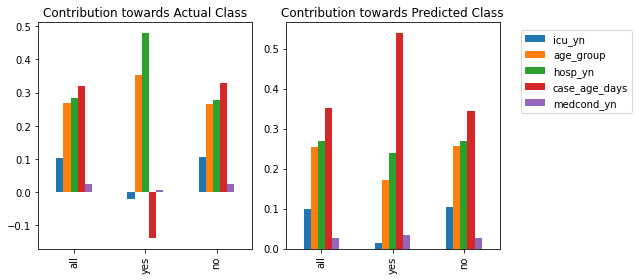

In [364]:
def feature_importances_combined(forest, count, data):
    
    # 2 types of importances, 3 classes, N columns
    
    N = len(data.X_test.columns)
    totals = np.zeros([2, 3, N])
    
    # Tally individual tree scores for each
    
    for index in range(count):
        dtree = forest.estimators_[index]
        prev_prediction, i11, i12, i13 = feature_importances(dtree.tree_, data)
        _, i21, i22, i23 = feature_importances(dtree.tree_, data, prev_prediction)
        totals += [[i11, i12, i13], [i21, i22, i23]]
    
    # Normalize each result
    
    for i in range(2):
        for j in range(3):
            totals[i, j, :] /= np.abs(totals[i, j, :]).sum()
    
    # Display
    
    _, ax = plt.subplots(1, 2, figsize=(9,4))
    
    frame = pd.DataFrame(totals[0], 
        columns=data.X_test.columns, 
        index=["all", "yes", "no"])
    frame.plot(kind="bar", ax=ax[0], legend=False,
               title="Contribution towards Actual Class")
    
    frame = pd.DataFrame(totals[1], 
        columns=data.X_test.columns, 
        index=["all", "yes", "no"])
    frame.plot(kind="bar", ax=ax[1], 
               title="Contribution towards Predicted Class")
    
    plt.legend(loc=(1.1,0.6))


model = rforest(random_state=0)
model.fit(iter1.X_train, iter1.y_train)
feature_importances_combined(model, len(model.estimators_), iter1)

Predicted vs. Actual is interesting here, especially in the yes-only case. Case age featured greatly in the prediction, but the sum total was actually to push the tree away from the correct answer. This could be overfitting at play. I'm straying into discussion about scores again though, the point is that case_age_days features a lot in the decision tree.

This also echoes the the result from the original in-built method. I read the warning in the docs as a being about a flaw in method, but I think that was from the perspective of scoring features - it's actually quite relevant when just thinking about how the model is doing things, rather than how well it is doing things.

The same applies to icu and medcond on a lesser scale.

In [365]:
prediction = predict(rforest, iter1, training_only=True)
actual = iter1.y_train

display(confusion(actual, prediction))
display(class_metrics(confusion(actual, prediction)))

,Alive,Dead
Alive,6253,10
Dead,31,209


accuracy     0.993695
precision    0.954338
recall       0.870833
F1           0.910675
dtype: float64

Well, the F1 score for the training data is extremely high, vastly outperforming the other two models. Overfitting seems likely, so I'll move straight on to the test data.

In [366]:
prediction = predict(rforest, iter1)
actual = iter1.y_test

display(confusion(actual, prediction))
display(class_metrics(confusion(actual, prediction)))

,Alive,Dead
Alive,2644,47
Dead,58,38


accuracy     0.962325
precision    0.447059
recall       0.395833
F1           0.419890
dtype: float64

And indeed, the model scores much less well with the test data. It has fairly balanced precision and recall. The score is lower than it is for the fully adjusted linear model, but it is higher than the out-of-the-box logistic model.

It makes sense that the random forest tends to overfit - the number of free parameters is vastly greater, so it can mold itself to the data really, really well. In fact, it can capture the sample data so well that the differences between the sample and test data become very significant.

Now, for kfolding:

In [367]:
kfold(10, rforest, iter1)

accuracy     0.957912
precision    0.406748
recall       0.341486
F1           0.367855
dtype: float64

The F1 score is lower again - either we got lucky with the train-test split, or the model is overfitting even more having 90% of the data available to it. It might be interesting to revisit this with a random forest that has fewer nodes on each tree.

Part 5: Improvements
==

In terms of raw accuracy on the test data, the logistic model scores highest, with a score of 96%. The others are not far behind, both around 95%. (The linear one does need the threshold carefully adjusted for this, though)

This is around the same as a model that predicts all negatives, since only about 3.6% of the data is positive, which means we'd expect the baseline all-no classifier to get about 96% accuracy.

In [572]:
# How imbalanced was the original dataset?
(a1_data.death_yn == "Yes").sum() / len(a1_data)

0.036167922497308935

Of course, it is this imbalance in the data that makes accuracy a fairly terrible measure to begin with, unless we weight it in some way or rebalance the data.

Taking F1 as our measure, the ranking is the exact opposite: the linear performs best at around 0.46, the random forest managest about 0.36 when kfolding (0.41 for the train-test split) and the logistic model is at 0.30.

To summarize the thoughts about performance scattered above:

**Linear Regression**
   - Requires careful threshold tuning.
   - Once tuned, it performs relatively well - it manages a precision and recall of almost 0.5. 
   - Performs just as well in kfold as it does on training data, more or less. 
   - age_group and hosp_yn are by far the most significant weights. 
   - It seems to be unable to leverage icu - perhaps because of the encoding?
   

**Logistic Regression**
   - Similar weighting to the linear mode.
   - Performs much worse. This might be because I do not know how to tune it, though.
   - It's possible rebalancing the data could achieve the same affect as tuning.
   - Again, re-encoding icu might help.
   - Again, performs as well in kfold as in training data - no overfitting.
   

**Random Forest**
   - Much harder to interpret, but seems to have similar priorities regarding features to the other two.
   - Major difference with case_age_days - it seems to rely on it too much and overfit.
   - Performs vastly better on training data - overfitting is an issue.
   - Nonetheless, performs relatively well in kfold compared to the logistic regression.

Ideas for improvements:
   - Re-encode with dummy variables. (esp. relevant for linear & logistic models)
   - Re-balance data. (eps. relevant for logistic model)
   - Combine models, with weighting.
   - Remove case_age_days for random forest.
   - Add gender.
   - Add indicator for age missing.
  
**Note 1:** I was originally intending to include the threshold tuning for the linear model in part 5 instead of part 2. I know part 2 specifically asks for a threshold of 0.5, sorry! But the model was completely crippled without it. I'm mentioning this here beause if it oversteps the bounds of part 2 it could be considered a part of part 5 instead.

**Note 2:** Imputing age was a temporary measure to make interpreting the prototype model easy - it is such an important feature that it deserves at least a missing indicator.

Applying Suggestions: Data Prep
--

I'll start by creating some functions with which to apply suggestions, and then make a separate sectiontrying out various combinations of these.

I'm not going to try combining models until the very end,.

First, regarding data balancing. There are two main ways of doing this - dropping records with the majority class, or duplicating records with the minority class. 

Going into this I have higher hopes for duplication, since that doesn't involve discarding most of the data. Both have pros and cons though and I'll define both here.

In [573]:
def undersample(df):

    random = np.random.RandomState(42)
    
    yes_only = (df["death_yn"] == "Yes").astype(int)
    no_only = 1 - yes_only
    no_only_p = no_only / no_only.sum()
    
    target_count = yes_only.sum()
    choice = random.choice(df.index, target_count, replace=False, p=no_only_p)
    
    yes_records = df[yes_only == 1]
    no_records = df.loc[choice]
    
    return pd.concat([yes_records, no_records])
    

def oversample(df):
    
    random = np.random.RandomState(42)
    
    yes_only = (df["death_yn"] == "Yes").astype(int)
    no_only = 1 - yes_only
    yes_only_p = yes_only / yes_only.sum()
    
    target_count = no_only.sum()
    choice = random.choice(df.index, target_count, replace=True, p=yes_only_p)
    
    yes_records = df.loc[choice]
    no_records = df[no_only == 1]
    
    return pd.concat([yes_records, no_records])


# Quick test
for sample_method in [undersample, oversample]:
    print(sample_method.__name__)
    result = sample_method(a1_data)
    display((result.death_yn == "Yes").astype(int).value_counts())

undersample


1    336
0    336
Name: death_yn, dtype: int64

oversample


1    8954
0    8954
Name: death_yn, dtype: int64

Some feature sets. The two things being considered are the removal of case_age and the addition of gender.

In [574]:
base_features = [
    "icu_yn",
    "age_group",
    "hosp_yn",
    "medcond_yn",
    "death_yn"
]

gender_feature = [
    "sex"
]

case_age_feature = [
    "case_age_days"
]

# The first iteration was `base_features + case_age_feature`

A new encoding function for age, taking missing values into account.

In [684]:
def encode_age_with_indicator(df):

    # Replace "Unknown" with zero and add a "missing indicator"
    df["age_group_missing"] = (original.age_group == "Unknown").astype(int)
    df.age_group = original.age_group.replace("Unknown", "0")

    # The rest is the same as before.
    
    labels = sorted(df.age_group.unique())
    df.age_group = pd.Categorical(df.age_group, categories=labels, ordered=True)

    df.age_group = df.age_group.cat.codes
    age = df.age_group
    df.age_group = (age - age.min()) / (age.max() - age.min())

    
# Quick test
data = a1_data.copy()
encode_age_with_indicator(data)
columns = ["age_group", "age_group_missing"]
display(data[columns].head(3))
display(data[data.age_group_missing == True][columns].head(3))

,age_group,age_group_missing
0,0.444444,0
1,0.222222,0
2,0.222222,0


,age_group,age_group_missing
1130,0.0,1
1621,0.0,1
1875,0.0,1


Modify the previous encoding function to default to dummy variables. It does still allow for ordinal variables to be specified, though I'm not sure if I will use this.

In [685]:
def encode_single_ordinal2(series):
    
    encoding = {
        "No": 0,
        "Unknown": 1,
        "Yes": 2, 
    }
    
    new_series = series.replace(encoding)
    new_series = new_series.astype(str).replace(encoding).astype(int)
    new_series = (new_series - new_series.min()) / (new_series.max() - new_series.min())
    
    return new_series


def encode_single_dummy(df, column_name):
    
    dummies = pd.get_dummies(df[column_name])
    dummies.columns = column_name + "_" + dummies.columns.astype(str)
    
    new_df = df.drop(column_name, axis=1)
    new_df = pd.concat([new_df, dummies], axis=1)
    
    return new_df
    
    
def encode_mixed(df, ignore=[], ordinal=[]):
    
    original = df
    new_df = original.copy()

    for feature in original:

        if feature in ignore:
            continue
        
        if str(original.dtypes[feature]) != "category": 
            continue
            
        if feature in ordinal:
            new_df[feature] = encode_single_ordinal2(original[feature])  
        
        else:    
            new_df = encode_single_dummy(new_df, feature)
        
    return new_df
        

# Quick test
display(iter1_data.head(4))
display(encode_mixed(iter1_data, ignore=["age_group", "death_yn"]).head(4))

,icu_yn,age_group,hosp_yn,case_age_days,medcond_yn,death_yn
0,Unknown,30 - 39 Years,No,246,Unknown,No
1,Unknown,10 - 19 Years,No,134,No,No
2,Unknown,10 - 19 Years,No,219,Unknown,No
3,Unknown,20 - 29 Years,Unknown,114,Unknown,No


,age_group,case_age_days,death_yn,icu_yn_No,icu_yn_Unknown,icu_yn_Yes,hosp_yn_No,hosp_yn_Unknown,hosp_yn_Yes,medcond_yn_No,medcond_yn_Unknown,medcond_yn_Yes
0,30 - 39 Years,246,No,0,1,0,1,0,0,0,1,0
1,10 - 19 Years,134,No,0,1,0,1,0,0,1,0,0
2,10 - 19 Years,219,No,0,1,0,1,0,0,0,1,0
3,20 - 29 Years,114,No,0,1,0,0,1,0,0,1,0


Testing Suggestions: Data Prep
--

First, create convenience functions for displaying information about a model, since this will come up very often in the next section.

This is a long function, but it is just a summary of the various metrics split across cells in Part 2.

,intercept,icu_yn,age_group,hosp_yn,case_age_days,medcond_yn
0,-0.139605,0.047549,0.171153,0.1387,0.062157,0.023527


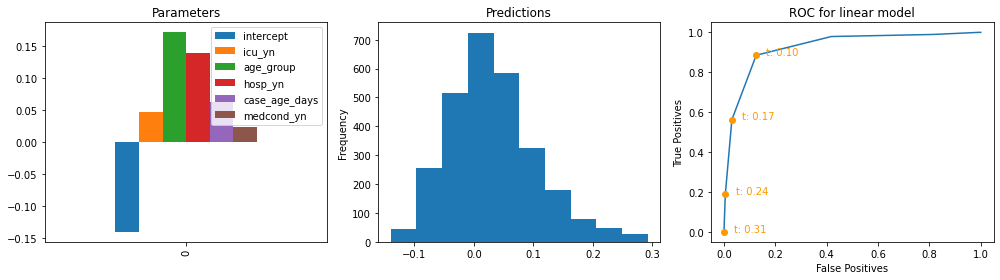

Area under ROC: 0.9261717297386612
Chosen threshold: 0.1919


,Training,Test,KFold
accuracy,0.955713,0.963402,0.959311
precision,0.419463,0.470000,0.448942
recall,0.520833,0.489583,0.493375
F1,0.464684,0.479592,0.467893


In [635]:
def show_linear(data, detailed=False):
    
    if detailed:
        
        model = linear()
        model.fit(data.X_train, data.y_train)

        model_info = pd.DataFrame(model.intercept_.reshape(1,1), columns=["intercept"])
        model_info[data.X_train.columns] = pd.DataFrame(model.coef_.reshape(1, model.coef_.size))

        _, ax = plt.subplots(1, 3, figsize=(14,4))

        display(model_info)
        model_info.plot(kind="bar", ax=ax[0], title="Parameters")

    prediction = predict(linear, data)
    actual = data.y_test

    if detailed:
        
        prediction.plot(kind="hist", ax=ax[1], title="Predictions")

        roc_data = roc(actual, prediction, np.linspace(-1, 1, 30))
        plot_roc(roc_data, ax[2])
        show_thresholds(roc_data)

        plt.show()

        print("Area under ROC:", auroc(roc_data)[0])
        
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        threshold = find_threshold(actual, prediction, np.linspace(-1,1,100))

    if detailed:
        print("Chosen threshold: %.04f" % threshold)
    
    prediction = predict(linear, data, threshold, training_only=True)
    actual = data.y_train
    training_metrics = class_metrics(confusion(actual, prediction))
    
    prediction = predict(linear, data, threshold)
    actual = data.y_test
    test_metrics = class_metrics(confusion(actual, prediction))
    
    kfold_metrics = kfold(10, linear, data, threshold)
    
    frame = pd.DataFrame([
        training_metrics,
        test_metrics,
        kfold_metrics
    ], index=["Training", "Test", "KFold"])
    display(frame.T)
    
    
show_linear(iter1, detailed=True)    

Same for the logistic model.

,intercept,icu_yn,age_group,hosp_yn,case_age_days,medcond_yn
0,-10.555918,1.83713,6.126942,2.690406,1.205046,0.719347


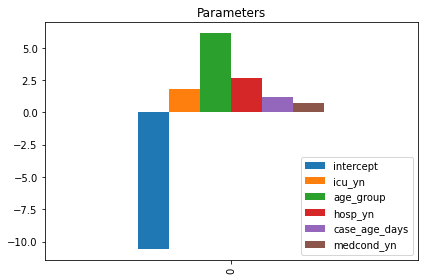

,Training,Test,KFold
accuracy,0.966169,0.967707,0.966631
precision,0.608696,0.588235,0.620144
recall,0.233333,0.208333,0.232206
F1,0.337349,0.307692,0.334285


In [642]:
def show_logistic(data, detailed=False):
    
    if detailed:
    
        model = logistic(random_state=0)
        model.fit(data.X_train, data.y_train)

        model_info = pd.DataFrame(model.intercept_.reshape(1,1), columns=["intercept"])
        model_info[data.X_train.columns] = pd.DataFrame(model.coef_.reshape(1, model.coef_.size))

        display(model_info)
        model_info.plot(kind="bar", title="Parameters")
        plt.show()
    
    prediction = predict(logistic, data, threshold, training_only=True)
    actual = data.y_train
    training_metrics = class_metrics(confusion(actual, prediction))
    
    prediction = predict(logistic, data, threshold)
    actual = data.y_test
    test_metrics = class_metrics(confusion(actual, prediction))
    
    kfold_metrics = kfold(10, logistic, data, threshold)
    
    frame = pd.DataFrame([
        training_metrics,
        test_metrics,
        kfold_metrics
    ], index=["Training", "Test", "KFold"])
    display(frame.T)
    
    
show_logistic(iter1, detailed=True)    

And finally, for the random forest.

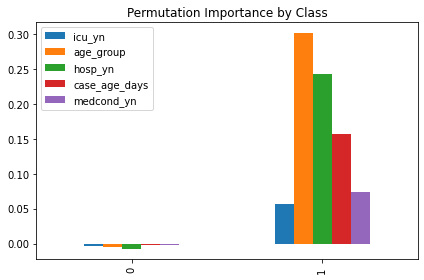

,Training,Test,KFold
accuracy,0.993695,0.962325,0.958988
precision,0.954338,0.447059,0.418004
recall,0.870833,0.395833,0.350738
F1,0.910675,0.419890,0.378750


In [653]:
def show_rforest(data, detailed=False):
    
    if detailed:
        
        frame = feature_importances_by_class(data)
        frame.plot(kind="bar", title="Permutation Importance by Class")
        plt.show()
    
    prediction = predict(rforest, data, threshold, training_only=True)
    actual = data.y_train
    training_metrics = class_metrics(confusion(actual, prediction))
    
    prediction = predict(rforest, data, threshold)
    actual = data.y_test
    test_metrics = class_metrics(confusion(actual, prediction))
    
    kfold_metrics = kfold(10, rforest, data, threshold)
    
    frame = pd.DataFrame([
        training_metrics,
        test_metrics,
        kfold_metrics
    ], index=["Training", "Test", "KFold"])
    display(frame.T)
    
    
show_rforest(iter1, detailed=True)    

Now, to try out some configurations.

Undersampling and Oversampling

In [678]:
iter_control = iter1
data = undersample(a1_data)[base_features + case_age_feature]

encode_age(data)
encode_all_ordinal(data)
normalize_case_age(data)

data.head(4)
data = get_case_study(data)

show_linear(data)
show_logistic(data)
show_rforest(data)

,Training,Test,KFold
accuracy,0.885106,0.896040,0.885404
precision,0.897436,0.903226,0.894390
recall,0.875000,0.875000,0.870978
F1,0.886076,0.888889,0.881276


,Training,Test,KFold
accuracy,0.893617,0.886139,0.889860
precision,0.886179,0.876289,0.881964
recall,0.908333,0.885417,0.898367
F1,0.897119,0.880829,0.889086


,Training,Test,KFold
accuracy,0.993617,0.881188,0.858670
precision,0.995816,0.900000,0.850625
recall,0.991667,0.843750,0.866511
F1,0.993737,0.870968,0.856362


Indicator variable for age. This has essentially no effect, which is not surprising since the number of missing values is small. I still think it is a nice touch though, and so will continue using it moving forward.

In [686]:
iter_control = iter1
data = a1_data[base_features + case_age_feature].copy()

encode_age_with_indicator(data)
encode_all_ordinal(data)
normalize_case_age(data)

data.head(4)
data = get_case_study(data)

show_linear(data)
show_logistic(data)
show_rforest(data)

,Training,Test,KFold
accuracy,0.955713,0.963402,0.959311
precision,0.419463,0.470000,0.448942
recall,0.520833,0.489583,0.493375
F1,0.464684,0.479592,0.467893


,Training,Test,KFold
accuracy,0.966169,0.967707,0.966523
precision,0.613636,0.588235,0.617114
recall,0.225000,0.208333,0.229176
F1,0.329268,0.307692,0.330548


,Training,Test,KFold
accuracy,0.993849,0.962325,0.956728
precision,0.954545,0.447059,0.383613
recall,0.875000,0.395833,0.333169
F1,0.913043,0.419890,0.354496


Dummy variables.

,intercept,age_group,case_age_days,age_group_missing,icu_yn_No,icu_yn_Unknown,icu_yn_Yes,hosp_yn_No,hosp_yn_Unknown,hosp_yn_Yes,medcond_yn_No,medcond_yn_Unknown,medcond_yn_Yes
0,-1.359240e+13,0.159242,0.041843,0.07282,-2.014195e+11,-2.014195e+11,-2.014195e+11,3.612274e+12,3.612274e+12,3.612274e+12,1.018154e+13,1.018154e+13,1.018154e+13


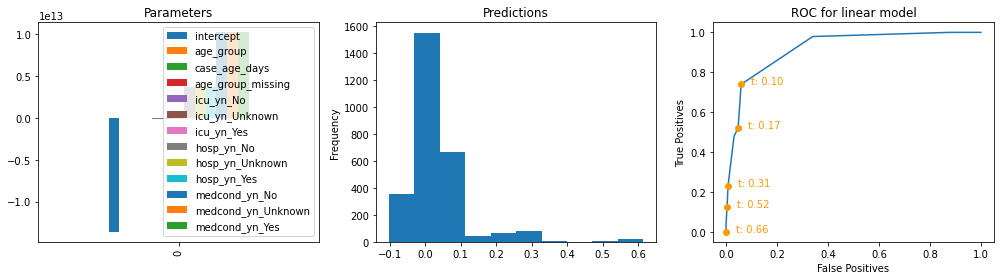

Area under ROC: 0.9202975965648672
Chosen threshold: 0.2525


,Training,Test,KFold
accuracy,0.953252,0.958378,0.954575
precision,0.401840,0.409091,0.405180
recall,0.545833,0.468750,0.517234
F1,0.462898,0.436893,0.451838


In [692]:
data = a1_data[base_features + case_age_feature].copy()

encode_age_with_indicator(data)
data = encode_mixed(data, ordinal=["death_yn"])
normalize_case_age(data)

data.head(4)
data = get_case_study(data)

show_linear(data, detailed=True)

,intercept,age_group,case_age_days,age_group_missing,icu_yn_No,icu_yn_Unknown,icu_yn_Yes,hosp_yn_No,hosp_yn_Unknown,hosp_yn_Yes,medcond_yn_No,medcond_yn_Unknown,medcond_yn_Yes
0,-8.396571,6.582157,1.175257,-0.001231,-0.959794,-0.123946,1.082625,-1.263088,-0.126933,1.388905,-0.491859,0.111532,0.379212


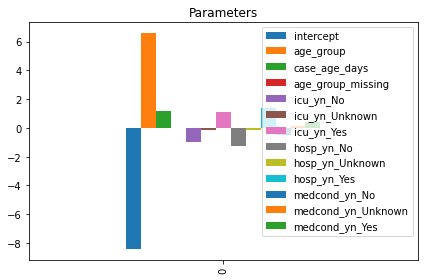

,Training,Test,KFold
accuracy,0.966477,0.967707,0.966523
precision,0.617021,0.583333,0.613074
recall,0.241667,0.218750,0.238456
F1,0.347305,0.318182,0.338607


In [693]:
show_logistic(data, detailed=True)

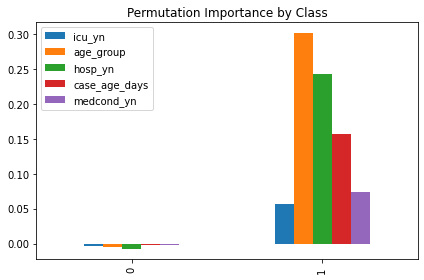

,Training,Test,KFold
accuracy,0.993849,0.960531,0.957266
precision,0.958716,0.423913,0.390674
recall,0.870833,0.406250,0.337586
F1,0.912664,0.414894,0.360263


In [694]:
show_rforest(data, detailed=True)

Adding in gender.

,intercept,icu_yn,age_group,hosp_yn,medcond_yn,case_age_days,sex,age_group_missing
0,-0.152069,0.046095,0.19257,0.137566,0.023736,0.061928,-0.015328,0.079361


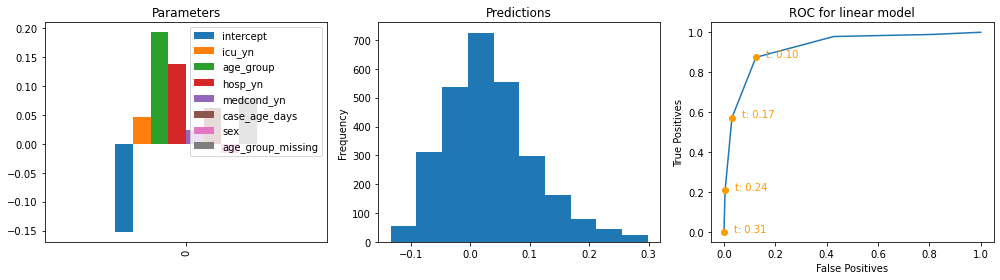

Area under ROC: 0.9249388401475312
Chosen threshold: 0.1919


,Training,Test,KFold
accuracy,0.956789,0.963402,0.959096
precision,0.431894,0.470588,0.447280
recall,0.541667,0.500000,0.505622
F1,0.480591,0.484848,0.472255


,intercept,icu_yn,age_group,hosp_yn,medcond_yn,case_age_days,sex,age_group_missing
0,-10.880423,1.751817,6.784823,2.632004,0.714089,1.19886,-0.599876,-0.000997


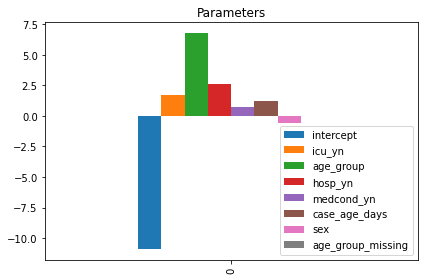

,Training,Test,KFold
accuracy,0.966785,0.968066,0.966738
precision,0.625000,0.606061,0.608557
recall,0.250000,0.208333,0.246053
F1,0.357143,0.310078,0.347303


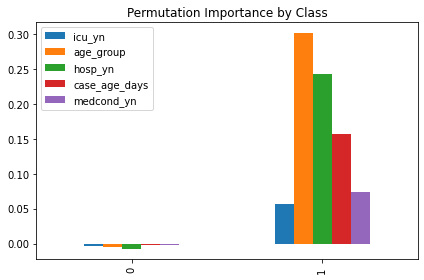

,Training,Test,KFold
accuracy,0.996309,0.960890,0.958558
precision,0.977876,0.413333,0.412563
recall,0.920833,0.322917,0.346873
F1,0.948498,0.362573,0.375316


In [701]:
data = a1_data[base_features + case_age_feature + gender_feature].copy()

encode_age_with_indicator(data)
data = data.replace("Male", 0).replace("Female", 1)
encode_all_ordinal(data)
normalize_case_age(data)

data.head(4)
data = get_case_study(data)

show_linear(data, detailed=True)
show_logistic(data, detailed=True)
show_rforest(data, detailed=True)